### Import modules

In [1]:
import os
import pickle

from os.path import isdir, join
from pathlib import Path

import librosa
import librosa.display

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LSTM, GRU, Bidirectional
from keras.utils import to_categorical

from sklearn.model_selection import KFold, train_test_split

/home/seongjinpark/.conda/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/seongjinpark/.conda/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/seongjinpark/.conda/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/seongjinpark/.conda/envs/pyt

In [2]:
tf.test.is_gpu_available()

True

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Check the location of WAV files

In [4]:
!ls ../audio/wavs

S02_Almost-All-Colleges.wav	     S19_Military-Personnel-Are.wav
S02_A-Monstrous-Shadow.wav	     S19_Nothing-Has-Been.wav
S02_An-Adult-Male.wav		     S19_Of-Course-Dear.wav
S02_Any-Organism-That.wav	     S19_Only-The-Most.wav
S02_Are-You-Looking.wav		     S19_Pam-Gives-Driving.wav
S02_Before-Thursdays-Exam.wav	     S19_Ralph-Prepared-Red.wav
S02_Carl-Lives-In.wav		     S19_She-Had-Your.wav
S02_Combine-All-The.wav		     S19_Steve-Collects-Rare.wav
S02_Continental-Drift-Is.wav	     S19_The-Moisture-In.wav
S02_Did-Shawn-Catch.wav		     S19_The-Small-Boy.wav
S02_Dont-Ask-Me.wav		     S19_The-Surplus-Shoes.wav
S02_Gently-Place-Jims.wav	     S19_The-Tooth-Fairy.wav
S02_George-And-Tom.wav		     S19_They-All-Like.wav
S02_Gregory-And-Tom.wav		     S19_They-Enjoy-It.wav
S02_He-Ate-Four.wav		     S19_They-Were-Already.wav
S02_He-Shrugged-Casually.wav	     S19_Those-Answers-Will.wav
S02_How-Oily-Do.wav		     S19_Thus-Technical-Efficiency.wav
S02_How-Permanent-Are.wav	     S19_Too-Much-Curiosity.wav

### Check wav files

In [5]:
audio_path = '../audio/wavs/'
print(os.listdir(audio_path)[:10])

['S09_He-Ate-Four.wav', 'S26_Those-Answers-Will.wav', 'S28_Try-To-Recall.wav', 'S03_Thus-Technical-Efficiency.wav', 'S25_Try-To-Recall.wav', 'S02_A-Monstrous-Shadow.wav', 'S21_A-Monstrous-Shadow.wav', 'S04_The-Small-Boy.wav', 'S28_Gently-Place-Jims.wav', 'S21_Military-Personnel-Are.wav']


### Extract mel-spectrogram and mfcc features

In [6]:
wav2idx = {}
melspec_dict = {}
mfcc_dict = {}

wav_names = [wav for wav in os.listdir(audio_path) if wav.endswith("wav")]

samples = 132300
max_len = 0

for i, w in enumerate(wav_names):
    wav2idx[w] = i
    wav_path = audio_path + w
    
    y, sr = librosa.load(wav_path) 
    
#     sample = sr * 5
    
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y)

    if len(y) > samples: # long enough
        y = y[0:0+samples]

    else: # pad blank
        padding = samples - len(y)
        offset = padding // 2
        y = np.pad(y, (offset, samples - len(y) - offset), 'constant')
    
    
    mel_data = librosa.feature.melspectrogram(y = y, sr= sr)
    mfcc_data = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 13)
    mfcc_delta = librosa.feature.delta(mfcc_data)
    mfcc_delta2 = librosa.feature.delta(mfcc_data, order = 2)

    mfcc = np.vstack((mfcc_data, mfcc_delta, mfcc_delta2))
#     if (np.shape(mel_data)[1] > max_len):
#         max_len = np.shape(mel_data)[1] 
    
    melspec_dict[i] = mel_data
    mfcc_dict[i] = mfcc

### Check the shape

In [7]:
print(max_len)
print(sr * 5)
for i in list(melspec_dict.keys())[:10]:
    print(melspec_dict[i].shape)

0
110250
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)


In [9]:
with open("../data/accented_data.csv", "r") as f:
    data = f.readlines()

In [10]:
X = []
X_wav = []
Y = []

zeros = np.zeros(128)
for i in range(1, len(data)):
    line = data[i].rstrip()
    
    accented, stim, wav_name = line.split(",")
    wav_idx = wav2idx[wav_name]
    X_wav.append(wav_idx)
#     x = np.zeros(shape = (128, max_len))
    # x_data = np.vstack((melspec_dict[wav_idx],mfcc_dict[wav_idx]))
    x_data = mfcc_dict[wav_idx]

#     print(np.shape(x), np.shape(x_data))
    
#     for i in range(0, np.shape(x_data)[0]):
#         for j in range(0, np.shape(x_data)[1]):
#             x[i][j] = x_data[i][j]
    
    X.append(x_data)
    Y.append(int(accented)-1)

print(np.shape(X))
print(np.shape(X_wav))
print(np.shape(Y))

(10806, 39, 259)
(10806,)
(10806,)


In [11]:
X_train, X_test, X_wav_train, X_wav_test, y_train, y_test = train_test_split(X, X_wav, Y, test_size=0.3, random_state=42)

In [12]:
# reshape
X_train = np.array(X_train)
X_test = np.array(X_test)
X_wav_train = np.array(X_wav_train)
X_wav_test = np.array(X_wav_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# X_train = X_train.reshape(X_train.shape[0], max_time, num_mel, 1)
# X_test = X_test.reshape(X_test.shape[0], max_time, num_mel, 1)



print(np.shape(X_train))
print(np.shape(X_test))

(7564, 39, 259)
(3242, 39, 259)


In [13]:
# hyperparameters
lr = 0.001
batch_size = 64
drop_out_rate = 0.25
num_dense_unit = 256
num_epochs = 50

num_mel = np.shape(X)[1]
max_time = np.shape(X)[2]

In [14]:
input_shape = (num_mel, max_time)

model = Sequential()

model.add(Bidirectional(LSTM(512, return_sequences=True), input_shape = (num_mel, max_time)))
model.add(Bidirectional(LSTM(512)))
model.add(Dropout(drop_out_rate))
model.add(Dense(num_dense_unit))
model.add(Dense(128))
model.add(Dense(1, activation='linear'))

# use adam optimizer
adam = keras.optimizers.Adam(lr = lr)

# compile the model
model.compile(optimizer=adam, loss="mse", metrics=["mse"])

model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 39, 1024)          3162112   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1024)              6295552   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 9,753,089
T

In [15]:
from datetime import datetime
logdir = "logs/scalars/accented_mfcc" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [16]:
num_epochs = 40
# model.load_weights('../data/RNN_model_100.h5')

history = model.fit(X_train, y_train, batch_size = batch_size, epochs = num_epochs, shuffle = False, class_weight = None,
         verbose = 1, validation_data = (X_test, y_test), callbacks=[tensorboard_callback])

model.save('../data/accented_mfcc_model_40.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 7564 samples, validate on 3242 samples


Epoch 1/40
7564/7564 [==============================] - 21s 3ms/step - loss: 2.0567 - mean_squared_error: 2.0567 - val_loss: 1.4653 - val_mean_squared_error: 1.4653
Epoch 2/40
7564/7564 [==============================] - 19s 2ms/step - loss: 1.4979 - mean_squared_error: 1.4979 - val_loss: 1.4911 - val_mean_squared_error: 1.4911
Epoch 3/40
7564/7564 [==============================] - 19s 3ms/step - loss: 1.4095 - mean_squared_error: 1.4095 - val_loss: 1.4954 - val_mean_squared_error: 1.4954
Epoch 4/40
7564/7564 [==============================] - 19s 2ms/step - loss: 1.3769 - mean_squared_error: 1.3769 - val_loss: 1.4304 - val_mean_squared_error: 1.4304
Epoch 5/40
7564/7564 [==============================] - 19s 2ms/step - loss: 1.5263 - mean_squared_error: 1.5263 - val_loss: 1.9686 - val_mean_squared_error: 1.9686
Epoch 6/40
7564/7564 [=========

In [17]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("MSE: %.5f" % (scores[1]))

MSE: 1.48104


### Plot the training process

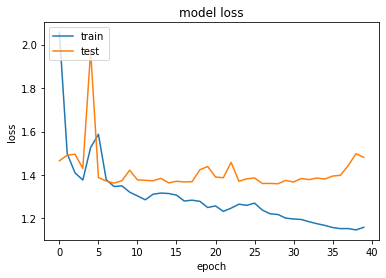

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The result looks like the model gets stable after 20 epochs

In [19]:
y_prediction = model.predict(X_test)

In [20]:
with open("../results/mfcc_40_accented_regression.txt", "w") as output:
    for i in range(len(y_test)):
        result = "%s\t%d\t%f\n" % (wav_names[X_wav_test[i]], y_test[i], y_prediction[i][0])
        output.write(result)

### Train and Test the model with Mel-Spectrogram

In [21]:
X_mel = []
X_wav = []
Y = []

zeros = np.zeros(128)
for i in range(1, len(data)):
    line = data[i].rstrip()
    
    accented, stim, wav_name = line.split(",")
    wav_idx = wav2idx[wav_name]
    X_wav.append(wav_idx)
    
#     x = np.zeros(shape = (128, max_len))
    # x_data = np.vstack((melspec_dict[wav_idx],mfcc_dict[wav_idx]))
    x_data = melspec_dict[wav_idx]

#     print(np.shape(x), np.shape(x_data))
    
#     for i in range(0, np.shape(x_data)[0]):
#         for j in range(0, np.shape(x_data)[1]):
#             x[i][j] = x_data[i][j]
    
    X_mel.append(x_data)
    Y.append(int(accented)-1)

print(np.shape(X))
print(np.shape(Y))

(10806, 39, 259)
(10806,)


In [22]:
X_mel_train, X_mel_test, X_wav_train, X_wav_test, y_train, y_test = train_test_split(X_mel, X_wav, Y, test_size=0.3, random_state=42)

In [23]:
# reshape
X_mel_train = np.array(X_mel_train)
X_mel_test = np.array(X_mel_test)
X_wav_train = np.array(X_wav_train)
X_wav_test = np.array(X_wav_test)
# X_train = X_train.reshape(X_train.shape[0], max_time, num_mel, 1)
# X_test = X_test.reshape(X_test.shape[0], max_time, num_mel, 1)



print(np.shape(X_mel_train))
print(np.shape(X_mel_test))

(7564, 128, 259)
(3242, 128, 259)


In [24]:
# hyperparameters
lr = 0.001
batch_size = 64
drop_out_rate = 0.25
num_dense_unit = 256
num_epochs = 50

num_melspec = np.shape(X_mel_train)[1]
max_time = np.shape(X_mel_train)[2]

In [25]:
input_shape = (num_melspec, max_time)

model_mel = Sequential()

model_mel.add(Bidirectional(LSTM(512, return_sequences=True), input_shape = (num_melspec, max_time)))
model_mel.add(Bidirectional(LSTM(512)))
model_mel.add(Dropout(drop_out_rate))
model_mel.add(Dense(num_dense_unit))
model_mel.add(Dense(128))
model_mel.add(Dense(1, activation='linear'))

# use adam optimizer
adam = keras.optimizers.Adam(lr = lr)

# compile the model
model_mel.compile(optimizer=adam, loss="mse", metrics=["mse"])

model_mel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 128, 1024)         3162112   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 1024)              6295552   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 9,753,089
Trainable params: 9,753,089
Non-trainable params: 0
_________________________________________________________________


In [26]:
from datetime import datetime
logdir = "logs/scalars/accented_melspec" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
num_epochs = 40
# model.load_weights('../data/RNN_model_100.h5')

history_mel = model_mel.fit(X_mel_train, y_train, batch_size = batch_size, epochs = num_epochs, shuffle = False, class_weight = None,
         verbose = 1, validation_data = (X_mel_test, y_test), callbacks=[tensorboard_callback])

model.save('../data/accented_melspec_model_40.h5')

Train on 7564 samples, validate on 3242 samples
Epoch 1/40
7564/7564 [==============================] - 61s 8ms/step - loss: 1.7141 - mean_squared_error: 1.7141 - val_loss: 1.4947 - val_mean_squared_error: 1.4947
Epoch 2/40
7564/7564 [==============================] - 62s 8ms/step - loss: 1.4458 - mean_squared_error: 1.4458 - val_loss: 1.4751 - val_mean_squared_error: 1.4751
Epoch 3/40
7564/7564 [==============================] - 61s 8ms/step - loss: 1.4187 - mean_squared_error: 1.4187 - val_loss: 1.4143 - val_mean_squared_error: 1.4143
Epoch 4/40
7564/7564 [==============================] - 61s 8ms/step - loss: 1.3747 - mean_squared_error: 1.3747 - val_loss: 1.3892 - val_mean_squared_error: 1.3892
Epoch 5/40
7564/7564 [==============================] - 61s 8ms/step - loss: 1.3456 - mean_squared_error: 1.3456 - val_loss: 1.3844 - val_mean_squared_error: 1.3844
Epoch 6/40
7564/7564 [==============================] - 61s 8ms/step - loss: 1.3307 - mean_squared_error: 1.3307 - val_loss: 1.

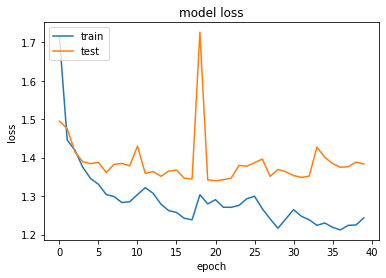

In [29]:
# summarize history for loss
plt.plot(history_mel.history['loss'])
plt.plot(history_mel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
y_mel_prediction = model_mel.predict(X_mel_test)

In [31]:
for i in range(10):
    print(wav_names[X_wav_test[i]], y_test[i], y_mel_prediction[i][0])

S22_Did-Shawn-Catch.wav 0 1.3060137
S26_Continental-Drift-Is.wav 3 2.5165117
S02_How-Oily-Do.wav 2 2.4040976
S25_He-Ate-Four.wav 3 3.0133507
S25_He-Ate-Four.wav 2 3.0133507
S24_Ralph-Prepared-Red.wav 3 0.79656273
S22_The-Moisture-In.wav 0 1.4710206
S04_Military-Personnel-Are.wav 5 2.4521656
S07_Did-Shawn-Catch.wav 4 4.277281
S07_The-Small-Boy.wav 4 3.4283938


In [32]:
with open("../results/accented_mel_40_accented_regression.txt", "w") as output:
    for i in range(len(y_test)):
        result = "%s\t%d\t%f\n" % (wav_names[X_wav_test[i]], y_test[i], y_mel_prediction[i][0])
        output.write(result)